## Fine-tune DistilBERT on AG News Topic Classification Dataset and use SHAP to produce explanations on model predictions

#### Install Dependencies

In [19]:
!pip install -q transformers
!pip install -q shap
!pip install -q datasets

### Setup Cuda and mount Google Drive to load pre-trained model checkpoint

In [20]:
import torch

#Utilise GPU for training/testing, if available
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU Available: ", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("No GPU Available, Switching To CPU.")

GPU Available:  Tesla T4


## Mount Google Drive & Ensure Access to Pretrained Model Checkpoint



In [21]:
from google.colab import drive
import sys

drive.mount('/content/gdrive')

PATH_TO_MODEL_DIR = "/content/gdrive/MyDrive/0db/"
sys.path.append(PATH_TO_MODEL_DIR)
!pwd
# change current working directory to /0db, where are Tokenizer module is 
%cd /content/gdrive/MyDrive/0db/
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/0db
/content/gdrive/MyDrive/0db
/content/gdrive/MyDrive/0db


## Load Model


In [22]:
import torch
from transformers import DistilBertForSequenceClassification

# Standard DistilBERT Class (pre-trained, standard 12 layers)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
).cuda()

PATH = "/content/gdrive/MyDrive/0db/classifier.pt"
model.load_state_dict(torch.load(PATH))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

<All keys matched successfully>

## Create A Tokenizer

In [23]:
from dbtokenizer import CustomTokenizer

tokenizer = CustomTokenizer().get_tokenizer()

## Load Data

In [24]:
from datasets import load_dataset

#Load train & test data
ag_news_train = load_dataset("ag_news", split='train')

#Small samples for testing on shapley
NUM_SAMPLES = 5
sample_titles = [row['text'] for row in ag_news_train][:NUM_SAMPLES]
sample_labels = [row['label'] for row in ag_news_train][:NUM_SAMPLES]

# get max sample length - information useful for padding when using the tokenizer
sample_max_length = CustomTokenizer().get_max_token_length(sample_titles)

## SHAP time!

In [25]:
import numpy as np
import scipy as sp

#SHAP Tokenization Function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length= sample_max_length + 10 , truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [26]:
import shap

explainer = shap.Explainer(f, tokenizer)
shap_values_bert = explainer(sample_titles, fixed_context=1)

## Generate Visualisations

In [27]:
# explanations item by item
shap.plots.text(shap_values_bert)

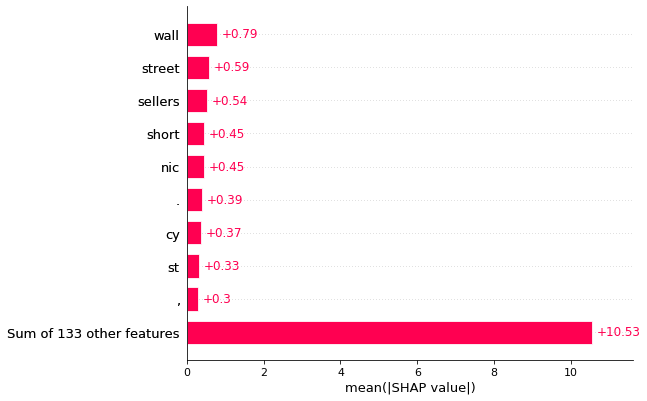

In [28]:
# most significant features according to shap values
shap.plots.bar(shap_values_bert.abs.mean(0))